In [162]:
import pandas as pd 
import numpy as np 

In [163]:
## Load the dataset
df = pd.read_csv("../Bank loan eligibility prediction/train_u6lujuX_CVtuZ9i.csv")
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [ ]:
# Dropping unnecessary columns
df = df.drop('Loan_ID', axis=1)

In [165]:
# Check for missing values
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

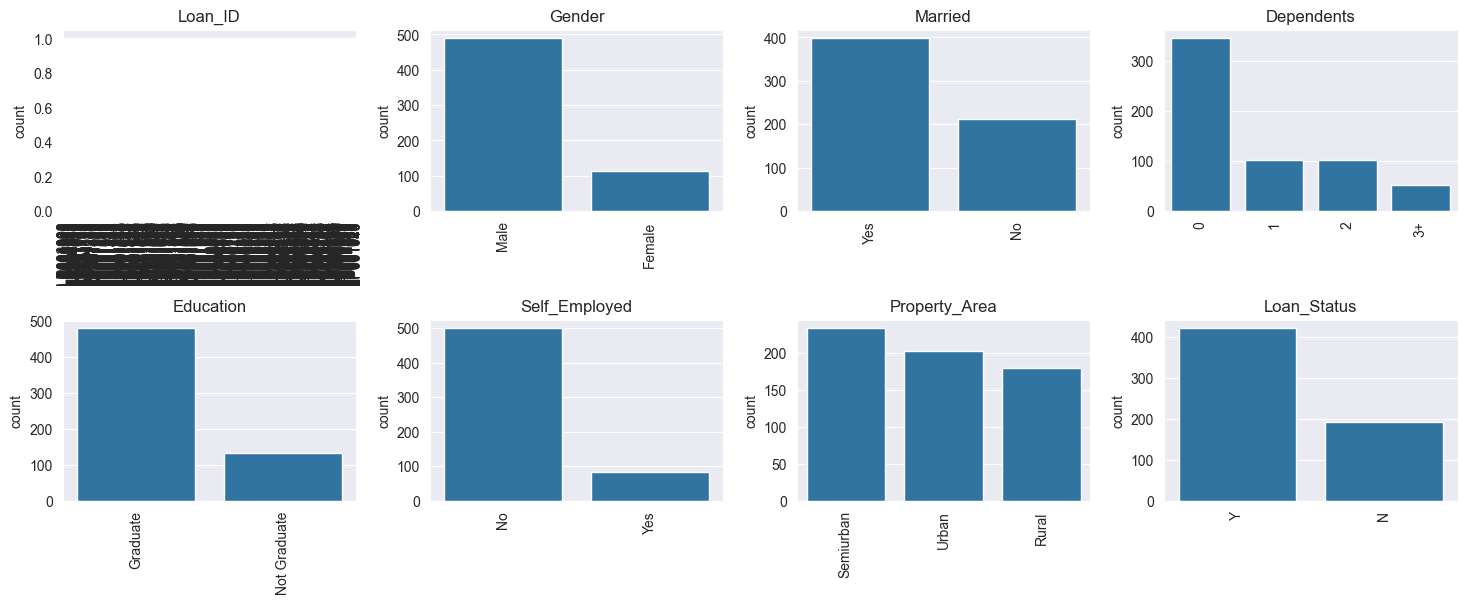

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of categorical features
sns.set_style('darkgrid')
sns.set_palette('tab10')

obj = (df.dtypes == 'object')
categorical_cols = list(obj[obj].index)
plt.figure(figsize=(18, 40))
index = 1

for col in categorical_cols:
    y = df[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.6, wspace=0.25) 
    sns.barplot(x = list(y.index), y = y).set_title(col)
    index += 1


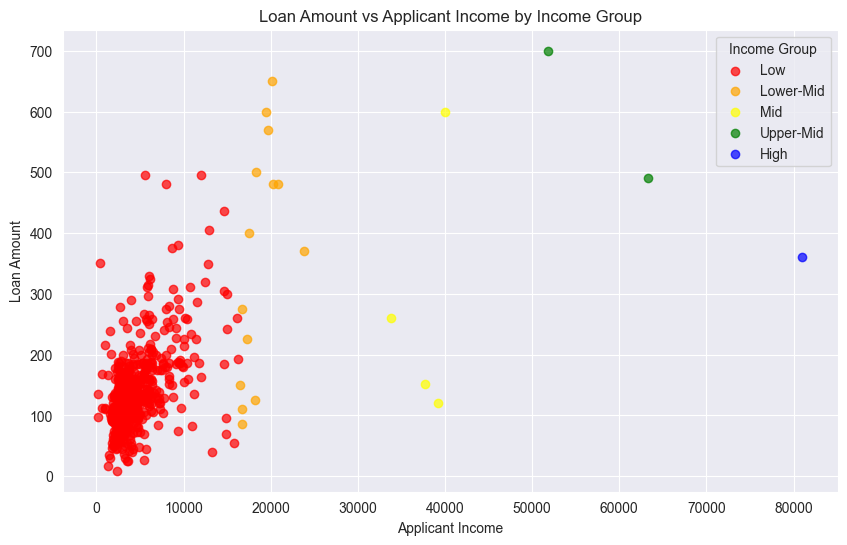

In [167]:
# Comparing the LoanAmount With the ApplicantIncome
df['IncomeGroup'] = pd.cut(df['ApplicantIncome'], bins=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])

color = {
    'Low': 'red',
    'Lower-Mid': 'orange',
    'Mid': 'yellow',
    'Upper-Mid': 'green',
    'High': 'blue'  
}

plt.figure(figsize=(10, 6))

for group in df['IncomeGroup'].unique():
    group_data = df[df['IncomeGroup'] == group]
    plt.scatter(group_data['ApplicantIncome'], group_data['LoanAmount'],
                 color=color[group], label=group, alpha=0.7)
                 
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Applicant Income by Income Group')
plt.legend(title='Income Group')
plt.grid(True)
plt.show()


In [168]:
# Check the data types of the columns
df.dtypes

Loan_ID                object
Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
IncomeGroup          category
dtype: object

In [169]:
df['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [170]:
# Check the Object columns in the dataset
df.select_dtypes(include=['object']).columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [171]:
# Check the Numeric columns in the dataset
df.select_dtypes(include=['int64', 'float64']).columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [ ]:
# Separate features (X) and target variable (y)
x = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [173]:
# Convert categorical variables to numerical using one-hot encoding
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History']
cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
             'Self_Employed', 'Property_Area']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

np.random.seed(42)

imputer = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='mean'), num_cols),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_cols)
    ],remainder='passthrough')

def add_features(x_df):
    x = x_df.copy()

    x['LoanAmount'] = x['LoanAmount'].fillna(0)
    x['TotalIncome'] = x['ApplicantIncome'] + x['CoapplicantIncome']
    x['EMI'] = x['LoanAmount'] / x['Loan_Amount_Term'].replace(0, 1)

    x['LoanAmount_log'] = x['LoanAmount'].apply(np.log1p)
    # x['TotalIncome_log'] = np.log1p(x['TotalIncome'].replace(0, 1))
    return x

fe = FunctionTransformer(add_features)

categorical_features = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']
le = LabelEncoder()
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
transformed = ColumnTransformer(
     transformers =  [("onehot_encoder",
                       onehot_encoder,
                         categorical_features)],
                           remainder='passthrough')

new_features = ['TotalIncome', 'EMI']
all_cols = num_cols + cat_cols + ['TotalIncome', 'EMI', 'LoanAmount_log']

pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= all_cols + ['LoanAmount_log']))),
    ('fe', fe),
    ('encoder', transformed),
    ('model', DecisionTreeClassifier()),
    ])

pipeline1 = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= all_cols))),
    ('fe', fe),
    ('encoder', transformed),
    ('model', RandomForestClassifier()),
    ])

pipeline2 = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= all_cols))),
    ('fe', fe),
    ('encoder', transformed),
    ('model', LogisticRegression()),
    ])

pipeline3 = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= all_cols))),
    ('fe', fe),
    ('encoder', transformed),
    ('model', SVC()),
    ])

pipeline4 = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= all_cols))),
    ('fe', fe),
    ('encoder', transformed),
    ('model', XGBClassifier()),
    ])


x = df.drop('Loan_Status', axis=1)
y = le.fit_transform(df['Loan_Status'])


In [175]:
from sklearn.model_selection import train_test_split, cross_val_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

pipeline.fit(x_train, y_train)

cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

ValueError: Shape of passed values is (491, 13), indices imply (491, 15)

In [ ]:
print(x_train.columns)
print(x_test.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [ ]:
y_proba = pipeline.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
pipeline.score(x_test, y_test)

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\3532693403.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\3532693403.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


0.7804878048780488

In [ ]:
y_pred = pipeline.predict(x_test)
y_pred

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\3532693403.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123

